In [1]:
import xarray as xr
import hvplot.xarray
import hvplot.pandas
import numpy as np
import pandas as pd
import holoviews as hv
import geoviews as gv
import matplotlib as mpl

import geopandas as gpd
from pathlib import Path

import warnings

warnings.filterwarnings('ignore')

hv.extension('bokeh')

In [2]:
RESERVOIR = '0518'

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))

selected_reservoirs = [
    '0505', # dumboor. India
    '0810', # sirindhorn, Thailand.
    '0830', # Krasoew, Thailand.
    '0502', # Bhakra dam, India.
    '0518', # Bhadra, India.
    '0349', # vaaldam, South Africa.
    '0464', # Sterkspruit, South Africa.
    '0214', # Cijara, Spain
    '1498', # Toledo bend, US
    # '0936', # Arrow, Canada
]

res_names = {
    '0505': 'Dumboor, In',
    '0810': 'Sirindhorn, Th',
    '0830': 'Krasoew, Th',
    '0502': 'Bhakra, In',
    '0518': 'Bhadra, In',
    '0349': 'Vaaldam, SA',
    '0464': 'Sterkspruit, SA',
    '0214': 'Cijara, Sp',
    '1498': 'Toledo Bend, US',
    '0936': 'Arrow, Ca'
}
RESERVOIR_NAME = res_names[RESERVOIR]

val_res_pt = val_pts.loc[val_pts['tmsos_id'].isin(selected_reservoirs)]
val_res_poly = val_polys.loc[val_polys['tmsos_id'].isin(selected_reservoirs)]

global_map = (
    val_res_pt.hvplot(
        geo=True, tiles='OSM'
    ) * val_res_pt[val_res_pt['tmsos_id'] == RESERVOIR].hvplot(
        geo=True, color='red', size=100, 
    )
).opts(
    title=f"Locations of validation reservoirs. {RESERVOIR_NAME}, highlighted in red"
)

global_map

:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]
   .Points.II :Points   [Longitude,Latitude]

In [3]:
(val_res_poly[val_res_poly['tmsos_id'] == RESERVOIR].hvplot(
    geo=True, tiles='OSM', shared_axes=False
)).opts(title=f"{RESERVOIR_NAME}")

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [4]:
BUFFER_M = 800 # m

utm_crs = val_polys[val_polys['tmsos_id'] == RESERVOIR].estimate_utm_crs()
print(f"UTM area of use: \n{utm_crs.area_of_use}")

buffered_roi_utm = val_res_poly[val_res_poly['tmsos_id'] == RESERVOIR].to_crs(utm_crs).buffer(BUFFER_M).to_crs('epsg:4326')
buffered_roi = buffered_roi_utm.to_crs('epsg:4326')

UTM area of use: 
- name: Between 72°E and 78°E, northern hemisphere between equator and 84°N, onshore and offshore. China. India. Kazakhstan. Kyrgyzstan. Maldives. Pakistan. Russian Federation. Tajikistan.
- bounds: (72.0, 0.0, 78.0, 84.0)


In [5]:
gd_track_fn = Path('../data/swot_orbit/swot_orbit.geojson')
gd_track = gpd.read_file(gd_track_fn)
gd_track

,ID_PASS,START_TIME,geometry
0,1,Day 01 00:00:00,"MULTIPOLYGON (((-75.45870 -77.45455, -75.73434..."
1,2,Day 01 00:51:30,"MULTIPOLYGON (((84.56768 77.75119, 84.60080 78..."
2,2,Day 01 00:51:30,"MULTIPOLYGON (((-180.00000 -52.37417, -180.000..."
3,3,Day 01 01:42:50,"MULTIPOLYGON (((-110.19573 -77.57156, -110.161..."
4,4,Day 01 02:34:20,"MULTIPOLYGON (((57.70091 77.75254, 57.69643 78..."
...,...,...,...
845,582,Day 21 18:10:40,"MULTIPOLYGON (((136.37126 77.75111, 136.40526 ..."
846,582,Day 21 18:10:40,"MULTIPOLYGON (((-180.00000 72.80747, -180.0000..."
847,583,Day 21 19:02:00,"MULTIPOLYGON (((-58.39258 -77.57164, -58.35950..."
848,584,Day 21 19:53:30,"MULTIPOLYGON (((109.50449 77.75255, 109.50090 ..."


In [6]:
gd_nadir_fn = Path('/tiger1/pdas47/tmsosPP/data/swot_orbit/sph_science_nadir/swot_science_orbit_sept2015-v2_nadir.shp')
gd_nadir = gpd.read_file(gd_nadir_fn)
gd_nadir.head()

,ID_PASS,START_TIME,geometry
0,1,Day 01 00:00:00,"LINESTRING (-75.40128 -77.54325, -67.74948 -77..."
1,2,Day 01 00:51:30,"LINESTRING (84.56135 77.66162, 92.52270 77.515..."
2,2,Day 01 00:51:30,"LINESTRING (-180.00000 -52.65544, -179.41330 -..."
3,3,Day 01 01:42:50,"LINESTRING (-110.20279 -77.66112, -107.53759 -..."
4,4,Day 01 02:34:20,"LINESTRING (57.70176 77.66297, 60.37721 77.650..."


In [7]:
buffered_roi_gdf = gpd.GeoDataFrame(buffered_roi).rename({0: 'geometry'}, axis=1) # .hvplot(alpha=0.2, lw=2)
buffered_roi_gdf.set_geometry('geometry', inplace=True)

In [8]:
import hvplot.pandas
import geoviews as gv
from holoviews import opts
import matplotlib as mpl
from shapely.geometry import box


gd_track_subset = gd_track[gd_track.intersects(buffered_roi.geometry.values[0])]
gd_nadir_subset = gd_nadir[gd_nadir.ID_PASS.isin(gd_track_subset.ID_PASS)]
gd_nadir_20km = gd_nadir_subset.to_crs(utm_crs).buffer(10000, cap_style='flat').to_crs('epsg:4326')
gd_nadir_20km = gpd.GeoDataFrame(gd_nadir_20km)
gd_nadir_20km = gd_nadir_20km.rename({0: 'geometry'}, axis=1)
gd_nadir_20km.set_geometry('geometry', inplace=True)

roi_gdf = gpd.GeoDataFrame(buffered_roi).rename({0: 'geometry'}, axis=1)
roi_gdf = roi_gdf.set_geometry('geometry')
roi_gdf['name'] = RESERVOIR_NAME
roi_hv = roi_gdf.hvplot(geo=True, alpha=0.8)

xlim=(int(buffered_roi.total_bounds[0])-1, int(buffered_roi.total_bounds[2])+1)
ylim=(int(buffered_roi.total_bounds[1])-1, int(buffered_roi.total_bounds[3])+1)
view_bounds = box(xlim[0]-1, ylim[0]-1, xlim[1]+1, ylim[1]+1)

cmap = mpl.colormaps['inferno']
gd_track_subset['color'] = [mpl.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, len(gd_track_subset.groupby('ID_PASS')))]
tracks_hv = gd_track_subset.clip(view_bounds).hvplot(
    geo=True, tiles='OSM', color=gd_track_subset['color'], alpha=0.5, line_width=2,
    xlim=xlim,
    ylim=ylim,
    tools=['hover'], hover_cols=['ID_PASS']
)

nadir_hv = gd_nadir_20km.hvplot(
    geo=True, alpha=0.5, line_width=2, color='lightgreen', line_dash='dashed',
    xlim=(int(buffered_roi.total_bounds[0])-1, int(buffered_roi.total_bounds[2])+1),
    ylim=(int(buffered_roi.total_bounds[1])-1, int(buffered_roi.total_bounds[3])+1),
)

(tracks_hv * nadir_hv * roi_hv).opts(
    title=f"SWOT Ground Tracks over {RESERVOIR_NAME}", width=400
)

:Overlay
   .WMTS.I       :WMTS   [Longitude,Latitude]
   .Polygons.I   :Polygons   [Longitude,Latitude]   (_color,ID_PASS)
   .Polygons.II  :Polygons   [Longitude,Latitude]
   .Polygons.III :Polygons   [Longitude,Latitude]

In [9]:
gd_track_subset

,ID_PASS,START_TIME,geometry,color
71,51,Day 02 18:52:20,"MULTIPOLYGON (((-10.74257 -77.57326, -10.73780...",#000004
213,148,Day 06 06:02:40,"MULTIPOLYGON (((-6.58903 77.75240, -6.60045 78...",#bc3754
476,329,Day 12 17:14:30,"MULTIPOLYGON (((-10.36577 -77.57144, -10.33074...",#fcffa4


### load data

In [10]:
# load
from pathlib import Path
import pandas as pd

swot_save_dir = Path('/tiger1/pdas47/tmsosPP/data/swot')
swot_save_dir.mkdir(exist_ok=True)

dsses = []
reservoirs = []
available = []
platforms = []
times = []
ds_dict = {reservoir_id: None for reservoir_id in selected_reservoirs}

for reservoir_id in selected_reservoirs:
    fp = swot_save_dir / f'{reservoir_id}.nc'

    if not fp.exists():
        reservoirs.append(reservoir_id)
        dsses.append(None)
        available.append(False)
        platforms.append(None)
        times.append(None)
        continue
    
    ds = xr.open_dataset(fp, chunks='auto', engine='netcdf4', decode_coords='all', )
    dsses.append(ds)
    reservoirs.extend([reservoir_id] * len(ds.time))
    available.extend([True] * len(ds.time))
    platforms.extend(['swot'] * len(ds.time))
    times.extend(ds.time.values)

ds = xr.concat(filter(lambda ds: ds is not None, dsses), dim='time').sortby('time')
ds_dict[reservoir_id] = ds

df = pd.DataFrame({
    'reservoir': reservoirs,
    'available': available,
    'platform': platforms,
    'time': times,
})

ds_dict = {f'{tmsos_id}': ds for tmsos_id, ds in zip(selected_reservoirs, dsses)}
df = pd.merge(df, val_res_poly[['tmsos_id', 'geometry']], left_on='reservoir', right_on='tmsos_id', suffixes=(False, False))
df = df.sort_values('time')
df.head()

,reservoir,available,platform,time,tmsos_id,geometry
51,0518,True,swot,2024-01-26,0518,"POLYGON ((75.59027 13.72694, 75.59109 13.72493..."
37,0502,True,swot,2024-01-27,0502,"POLYGON ((76.39041 31.54315, 76.39202 31.54278..."
11,0810,True,swot,2024-01-28,0810,"POLYGON ((105.37056 14.95278, 105.37065 14.952..."
38,0502,True,swot,2024-01-28,0502,"POLYGON ((76.39041 31.54315, 76.39202 31.54278..."
87,0214,True,swot,2024-01-29,0214,"POLYGON ((-4.96212 39.42249, -4.96139 39.42138..."


Text(0.5, 1.0, 'HLS Data downloaded for selected reservoirs')

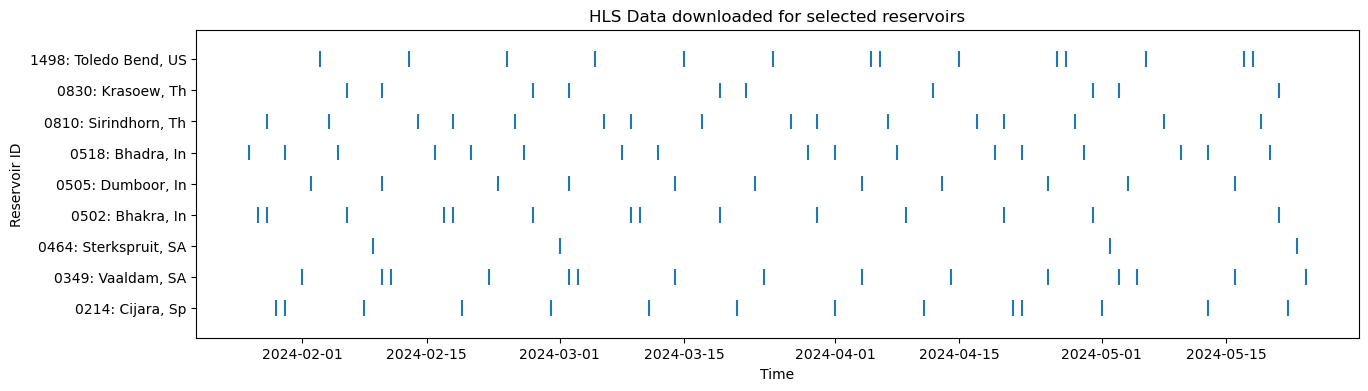

In [11]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 4))

yticks = []
ytick_labels = []
for i, reservoir_id in enumerate(df.groupby('reservoir').groups):
    data = df.loc[df['reservoir'] == reservoir_id]['time'].reset_index(drop=True)
    name = res_names[reservoir_id]
    ax.eventplot(data, orientation='horizontal', linelengths=0.5, lineoffsets=i)
    yticks.append(i)
    ytick_labels.append(f"{reservoir_id}: {name}")

ax.set_yticks(ticks=yticks, labels=ytick_labels)
ax.set_ylabel('Reservoir ID')
ax.set_xlabel('Time')

ax.set_title('HLS Data downloaded for selected reservoirs')

## plot data for a single reservoir

In [12]:
ds = ds_dict[RESERVOIR]
ds

<xarray.Dataset> Size: 46MB
Dimensions:            (time: 17, y: 344, x: 283)
Coordinates:
  * x                  (x) float64 2kB 5.484e+05 5.485e+05 ... 5.766e+05
  * y                  (y) float64 3kB 1.489e+06 1.489e+06 ... 1.523e+06
    reservoir          <U4 16B ...
    spatial_ref        int64 8B ...
    crs                int64 8B ...
  * time               (time) datetime64[ns] 136B 2024-01-26 ... 2024-05-20
Data variables:
    water_area         (time, y, x) float32 7MB dask.array<chunksize=(17, 344, 283), meta=np.ndarray>
    water_area_qual    (time, y, x) float32 7MB dask.array<chunksize=(17, 344, 283), meta=np.ndarray>
    water_frac         (time, y, x) float32 7MB dask.array<chunksize=(17, 344, 283), meta=np.ndarray>
    water_frac_uncert  (time, y, x) float32 7MB dask.array<chunksize=(17, 344, 283), meta=np.ndarray>
    wse                (time, y, x) float32 7MB dask.array<chunksize=(17, 344, 283), meta=np.ndarray>
    wse_uncert         (time, y, x) float32 7MB dask.array<chunksize=(17, 344, 283), meta=np.ndarray>
    wse_qual           (time, y, x) float32 7MB dask.array<chunksize=(17, 344, 283), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    source:                        Ka-band radar interferometer
    history:                       2024-02-20T19:12:36Z : Creation
    platform:                      SWOT
    references:                    V1.2.1
    ...                            ...
    x_min:                         433500.0
    x_max:                         579700.0
    y_min:                         1508700.0
    y_max:                         1654800.0
    institution:                   CNES
    product_version:               01

In [13]:
import holoviews as hv
import hvplot.xarray

ds['wse'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(80, 100) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Water Surface Elevation (m)'
) + ds['wse_qual'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=ds.rio.crs
).opts(
    title='Water Surface Elevation Uncertainty (m)'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'2ef54b29-be5b-4010-be71-742ee3016651': {'version…

In [14]:
import holoviews as hv

ds['water_frac'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Water Fraction'
) + ds['water_frac_uncert'].hvplot(
    x='x', y='y', rasterize=True, clim=(0, 1), aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=ds.rio.crs
).opts(
    title='Water Fraction Uncertainty'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'705a5590-99cd-47d0-95f2-6f89b2244bdb': {'version…

In [15]:
import holoviews as hv

ds['water_area'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1e4) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Water Area'
) + ds['water_area_qual'].hvplot(
    x='x', y='y', rasterize=True, clim=(0, 3), aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=ds.rio.crs
).opts(
    title='Water Area Quality (0=nominal,1=suspect,2=degraded,3=bad)'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'a6ab14ed-23fa-4169-9919-af53a4fe9e95': {'version…

### Classify water for single reservoir

In [16]:
import rioxarray

ds = ds.rio.set_spatial_dims('y', 'x')
ds = ds.rio.write_crs(utm_crs)
ds = ds.rio.clip(buffered_roi.to_crs(ds.rio.crs).geometry.values)
ds

<xarray.Dataset> Size: 23MB
Dimensions:            (x: 191, y: 249, time: 17)
Coordinates:
  * x                  (x) float64 2kB 5.53e+05 5.531e+05 ... 5.719e+05 5.72e+05
  * y                  (y) float64 2kB 1.494e+06 1.494e+06 ... 1.518e+06
    reservoir          <U4 16B ...
    crs                int64 8B ...
  * time               (time) datetime64[ns] 136B 2024-01-26 ... 2024-05-20
    spatial_ref        int64 8B 0
Data variables:
    water_area         (time, y, x) float32 3MB dask.array<chunksize=(17, 249, 191), meta=np.ndarray>
    water_area_qual    (time, y, x) float32 3MB dask.array<chunksize=(17, 249, 191), meta=np.ndarray>
    water_frac         (time, y, x) float32 3MB dask.array<chunksize=(17, 249, 191), meta=np.ndarray>
    water_frac_uncert  (time, y, x) float32 3MB dask.array<chunksize=(17, 249, 191), meta=np.ndarray>
    wse                (time, y, x) float32 3MB dask.array<chunksize=(17, 249, 191), meta=np.ndarray>
    wse_uncert         (time, y, x) float32 3MB dask.array<chunksize=(17, 249, 191), meta=np.ndarray>
    wse_qual           (time, y, x) float32 3MB dask.array<chunksize=(17, 249, 191), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    source:                        Ka-band radar interferometer
    history:                       2024-02-20T19:12:36Z : Creation
    platform:                      SWOT
    references:                    V1.2.1
    ...                            ...
    x_min:                         433500.0
    x_max:                         579700.0
    y_min:                         1508700.0
    y_max:                         1654800.0
    institution:                   CNES
    product_version:               01

In [17]:
from rasterio.crs import CRS
import rioxarray
import dask
import numpy as np
from tmsswot.data import get_occurrence_like

pekel_dir = Path('../data/pekel/occurrence_nc')
occurrence = get_occurrence_like(buffered_roi, reproject_match=ds['water_frac'], pekel_dir=pekel_dir, stretching_factor=1.02)
occurrence

ROI CRS:  epsg:4326
roi (epsg:4326) total bounds:  [75.48955628 13.51082878 75.66628249 13.73585146]
tile limits:  70 10 80 20
tiles:  ['70E_10N', '70E_20N', '80E_10N', '80E_20N']


<xarray.DataArray 'occurrence' (y: 249, x: 191)> Size: 380kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int64 8B 1
  * x            (x) float64 2kB 5.53e+05 5.531e+05 ... 5.719e+05 5.72e+05
  * y            (y) float64 2kB 1.494e+06 1.494e+06 ... 1.518e+06 1.518e+06
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  nan

In [18]:
occurrence.hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 100) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Occurrence (%)'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'56cdad5d-1678-4315-b3dd-37b51666805e': {'version…

In [19]:
%load_ext autoreload
%autoreload 2

In [20]:
from tmsswot.classify import get_swot_missing_data

def classify_swot(
        swot_ds, 
        roi, 
        occurrence, 
        water_frac_threshold=0.7, 
        area_qual_threshold=2, 
        wse_qual_threshold=1, 
        zg_omega=0.3
    ):
    swot_ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    swot_ds.rio.write_crs(CRS.from_wkt(swot_ds.spatial_ref.attrs['crs_wkt']), inplace=True)

    water_map = (swot_ds['water_frac'].where(swot_ds['water_area_qual'] <= area_qual_threshold) > water_frac_threshold) * 1
    water_map = water_map.rio.set_crs(swot_ds.rio.crs)
    water_map.attrs['standard_name'] = "surface_water"
    water_map.attrs['long_name'] = "Surface water of lake/reservoir observed by SWOT"
    water_map = water_map.rename('surface_water')

    missing_mask = get_swot_missing_data(swot_ds, roi, area_qual_threshold, wse_qual_threshold)
    # enhance using historical occurrence data
    def zg(water_map_block):
        times = water_map_block.time
        res = xr.zeros_like(water_map_block)

        for i, time in enumerate(times):
            water_map_slice = water_map_block.sel(time=time)
            if missing_mask['missing_mask_rate'].sel(time=time) <= 0.95:
                mask_slice = missing_mask['missing_mask'].sel(time=time)
                
                occurrence_slice = xr.where(~mask_slice, occurrence, np.nan)
                occurrence_slice = xr.where(water_map_slice==1, occurrence_slice, 0)
                occurrence_counts, occurrence_values = np.histogram(occurrence_slice.values, bins=99, range=(1, 100))
                count_threshold = np.nanmean(occurrence_counts) * zg_omega
                occurrence_idx = np.nanargmax(np.where(occurrence_counts > count_threshold) if (occurrence_counts > count_threshold).sum() > 0 else [0])
                occurrence_idx = np.nan if occurrence_idx == 0 else occurrence_idx
                
                pekel_estimated_map = (occurrence >= occurrence_idx)
        
                corrected_map = xr.where(
                    missing_mask['missing_mask'].sel(time=time) == 1, 
                    pekel_estimated_map,
                    water_map_slice
                )
                res.data[i] = corrected_map
            else:
                res.data[i] = np.full_like(water_map_slice, 2)
        
        return res
    
    water_map = water_map.chunk({'time': 50, 'x': -1, 'y': -1})
    water_map = water_map.transpose('time', 'y', 'x')
    water_map_uncorrected = water_map.copy()
    water_map = water_map.map_blocks(
        zg, template=water_map
    ).rename("surface_water")
    water_map.rio.set_nodata(2, inplace=True)
    
    # water_map_area = swot_ds['water_area'].where(water_map == 1).sum(dim=('x', 'y')) * 1e-6
    water_frac_pixels = xr.where(water_map!=1, np.nan, swot_ds['water_frac'].fillna(1e4))
    water_map_area = water_frac_pixels.sum(dim=('x', 'y')) * 1e-6 * 1e4 # km^2
    water_map_area.attrs['standard_name'] = "surface_water_area"
    water_map_area.attrs['long_name'] = "Surface water area of lake/reservoir observed by SWOT"
    water_map_area.attrs['unit'] = "km^2"
    water_map_area = water_map_area.rename('surface_water_area')

    water_surface_elevation_raster = xr.where(missing_mask['missing_mask'], np.nan, swot_ds['wse'])
    water_surface_elevation_raster = water_surface_elevation_raster.where(swot_ds['wse_qual'] <= wse_qual_threshold)
    # water_surface_elevation_raster = xr.where(water_map_uncorrected == 1, water_surface_elevation_raster, np.nan).rename('surface_water_elevation_raster')
    water_surface_elevation_raster = xr.where(water_map == 1, water_surface_elevation_raster, np.nan).rename('surface_water_elevation_raster')
    water_surface_elevation_raster.attrs['standard_name'] = "surface_water_elevation_raster"
    water_surface_elevation_raster.attrs['long_name'] = "Surface water elevation of lake/reservoir observed by SWOT"
    water_surface_elevation_raster.attrs['unit'] = "m"

    water_surface_elevation = water_surface_elevation_raster.mean(dim=['x', 'y'])
    water_surface_elevation.attrs['standard_name'] = "surface_water_elevation"
    water_surface_elevation.attrs['long_name'] = "Water Surface Elevation observed by SWOT"
    water_surface_elevation.attrs['unit'] = "m"
    water_surface_elevation = water_surface_elevation.rename('surface_water_elevation')

    storage_change = (water_map_area[1:] - water_map_area[:-1]) * (water_surface_elevation[1:] + water_surface_elevation[:-1]) * 0.5 * 1e6
    storage_change.attrs['standard_name'] = "storage_change"
    storage_change.attrs['long_name'] = "Change in storage of lake/reservoir observed by SWOT"
    storage_change.attrs['unit'] = "m^3"
    storage_change = storage_change.rename('storage_change')

    time_since_last_obs = (water_map_area.time[1:] - water_map_area.time[:-1]).astype('timedelta64[D]')
    time_since_last_obs.attrs['standard_name'] = "time_since_last_obs"
    time_since_last_obs.attrs['long_name'] = "Time since last observation of lake/reservoir observed by SWOT"
    time_since_last_obs.attrs['unit'] = "days"
    time_since_last_obs = time_since_last_obs.rename('time_since_last_obs')

    swot_ds = xr.merge([
        water_map, water_map_area, water_surface_elevation_raster, 
        water_surface_elevation, missing_mask, storage_change, time_since_last_obs
    ])

    return swot_ds

In [21]:
# from tmsswot.classify import classify_swot

swot_ds = classify_swot(ds, buffered_roi, occurrence)
swot_ds

<xarray.Dataset> Size: 16MB
Dimensions:                         (x: 191, y: 249, time: 17)
Coordinates:
  * x                               (x) float64 2kB 5.53e+05 ... 5.72e+05
  * y                               (y) float64 2kB 1.494e+06 ... 1.518e+06
  * time                            (time) datetime64[ns] 136B 2024-01-26 ......
    reservoir                       <U4 16B '0518'
    crs                             int64 8B 0
    spatial_ref                     int64 8B 0
Data variables:
    surface_water                   (time, y, x) int64 6MB dask.array<chunksize=(17, 249, 191), meta=np.ndarray>
    surface_water_area              (time) float32 68B dask.array<chunksize=(17,), meta=np.ndarray>
    surface_water_elevation_raster  (time, y, x) float32 3MB dask.array<chunksize=(17, 249, 191), meta=np.ndarray>
    surface_water_elevation         (time) float32 68B dask.array<chunksize=(17,), meta=np.ndarray>
    missing_mask                    (time, y, x) int64 6MB dask.array<chunksize=(17, 249, 191), meta=np.ndarray>
    missing_mask_rate               (time) float64 136B dask.array<chunksize=(17,), meta=np.ndarray>
    storage_change                  (time) float32 68B dask.array<chunksize=(17,), meta=np.ndarray>
    time_since_last_obs             (time) timedelta64[ns] 136B NaT ... NaT
Attributes:
    standard_name:  surface_water
    long_name:      Surface water of lake/reservoir observed by SWOT

In [22]:
swot_ds.load()

<xarray.Dataset> Size: 16MB
Dimensions:                         (x: 191, y: 249, time: 17)
Coordinates:
  * x                               (x) float64 2kB 5.53e+05 ... 5.72e+05
  * y                               (y) float64 2kB 1.494e+06 ... 1.518e+06
  * time                            (time) datetime64[ns] 136B 2024-01-26 ......
    reservoir                       <U4 16B '0518'
    crs                             int64 8B 0
    spatial_ref                     int64 8B 0
Data variables:
    surface_water                   (time, y, x) int64 6MB 2 2 2 2 2 ... 2 2 2 2
    surface_water_area              (time) float32 68B 0.0 5.986e+03 ... 0.0 0.0
    surface_water_elevation_raster  (time, y, x) float32 3MB nan nan ... nan nan
    surface_water_elevation         (time) float32 68B nan 654.3 nan ... nan nan
    missing_mask                    (time, y, x) int64 6MB 1 1 1 1 1 ... 1 1 1 1
    missing_mask_rate               (time) float64 136B 0.9771 0.9425 ... 0.9759
    storage_change                  (time) float32 68B nan 0.0 nan ... nan nan
    time_since_last_obs             (time) timedelta64[ns] 136B NaT ... NaT
Attributes:
    standard_name:  surface_water
    long_name:      Surface water of lake/reservoir observed by SWOT

In [23]:
swot_ds['surface_water'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Surface Water'
) + ds['water_frac'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1), # crs=ds.rio.crs
).opts(
    title='Water Fraction'
) + ds['water_area_qual'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 3) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Water Area Quality'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'55acaca8-7054-4e6f-a105-ebd6a1733663': {'version…

In [24]:
gd_nadir_20km.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
swot_ds.rio.clip(gd_nadir_20km.to_crs(swot_ds.rio.crs).geometry.values, invert=True)

<xarray.Dataset> Size: 16MB
Dimensions:                         (x: 191, y: 249, time: 17)
Coordinates:
  * x                               (x) float64 2kB 5.53e+05 ... 5.72e+05
  * y                               (y) float64 2kB 1.494e+06 ... 1.518e+06
  * time                            (time) datetime64[ns] 136B 2024-01-26 ......
    reservoir                       <U4 16B '0518'
    crs                             int64 8B 0
    spatial_ref                     int64 8B 0
Data variables:
    surface_water                   (time, y, x) int64 6MB 2 2 2 2 2 ... 2 2 2 2
    surface_water_area              (time) float32 68B 0.0 5.986e+03 ... 0.0 0.0
    surface_water_elevation_raster  (time, y, x) float32 3MB nan nan ... nan nan
    surface_water_elevation         (time) float32 68B nan 654.3 nan ... nan nan
    missing_mask                    (time, y, x) int64 6MB 1 1 1 1 1 ... 1 1 1 1
    missing_mask_rate               (time) float64 136B 0.9771 0.9425 ... 0.9759
    storage_change                  (time) float32 68B nan 0.0 nan ... nan nan
    time_since_last_obs             (time) timedelta64[ns] 136B NaT ... NaT
Attributes:
    standard_name:  surface_water
    long_name:      Surface water of lake/reservoir observed by SWOT

In [26]:
((
    swot_ds['surface_water']).hvplot(
        x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1), # crs=swot_ds.rio.crs
).opts(
    title='Surface water'
) + (
    swot_ds['missing_mask']).hvplot(
        x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1), cmap='RdYlGn_r' # , geo=True, # crs=swot_ds.rio.crs
).opts(
    title='Missing mask'
) + (
    swot_ds['surface_water_elevation_raster']).hvplot(
        x='x', y='y', rasterize=True, aspect='equal'
).opts(
    title='Water Elevation'
) + (
    swot_ds['surface_water_area']).hvplot(
        label='Area', kind='scatter'
).opts(
    width=400, title='Area'
) + (
swot_ds['surface_water_elevation']).hvplot(
    label='Area', kind='scatter'
).opts(
    width=400, title='Water Surface Elevation'
) + (
swot_ds['missing_mask_rate']).hvplot(
    label='Area', kind='scatter'
).opts(
    width=400, title='Missing data rate'
)).cols(2)

BokehModel(combine_events=True, render_bundle={'docs_json': {'7c108cfd-c03c-43d6-bcd1-a334d1ef434e': {'version…

In [27]:
swot_ds.mean(dim=('x', 'y')).hvplot(
    x='surface_water_area', y='surface_water_elevation', kind='scatter', by='time', 
    c='missing_mask_rate', cmap='kr', clabel='Fraction of missing data over reservoir',
).opts(
    xlabel='Water Area (km2)', ylabel='Surface Water Elevation (m)',
    title=f'Area-Elevation curve for {RESERVOIR_NAME}'
)

:NdOverlay   [time]
   :Scatter   [surface_water_area]   (surface_water_elevation,missing_mask_rate)

In [28]:
swot_ds['storage_change'].hvplot( # not working
    x='time', label='∆S'
)

:Curve   [time]   (storage_change)

# Issue of missing data

Due to partial coverage by the SWOT satellite's KaRIN sensor's swath, there may be partial data. One way to handle this is to use resample the dataset temporally to that of the repeat period of the satellite. This way, even if a reservoir is partially observed in a single pass, by combining multiple passes a more complete picture can be obtained.

We will resample the data to a 21 day interval to match the repeat period of the SWOT satellite.

In [29]:
import dask.array 

rs_area_qual = ds['water_area_qual'] # .resample(time='21D').reduce(np.nanmean)


def _swot_quality_bits_resampler(a, rs_area_qual, **axis):
    # res = np.full_like(a, np.nan)
    # pick value of area from raster that has the best quality (i.e. lower value of area_qual)
    # print(a, xr.DataArray(a).dim_0.values)
    # rs_area_qual_idx = rs_area_qual.isel(time=xr.DataArray(a).dim_0.values).reduce(
    # print(xr.DataArray(a).data, '\n\n')
    rs_area_qual_idx = rs_area_qual.isel(time=xr.DataArray(a).dim_0.values).reduce(
        np.argmin, dim='time'
    ) # array containing the index along a.shape[0] from which to pick the value of the 
      # resulting array
    # print(rs_area_qual_idx)
    # rs_area_composite = np.take_along_axis(a, rs_area_qual_idx, axis=0)
    # rs_area_composite = np.full_like(rs_area_qual_idx, np.nan, dtype=a.dtype)
    # rs_area_composite = np.choose(rs_area_qual_idx, a)

    return rs_area_qual_idx

def swot_area_resampler(a, rs_area_qual, **axis):
    rs_area_qual_idx = _swot_quality_bits_resampler(a, rs_area_qual, **axis)
    rs_area_composite = np.choose(rs_area_qual_idx.data, a)
    return rs_area_composite

def swot_area_qual_bits_resampler(a, rs_area_qual, **axis):
    print(xr.DataArray(a).values.shape, '\n\n')
    rs_area_qual_idx = _swot_quality_bits_resampler(a, rs_area_qual, **axis)
    return rs_area_qual_idx

resampled_qual_bits_idx = ds[['water_frac', 'water_area_qual', 'wse']].resample(time='21D')
resampled_area_template = ds[['water_frac']].resample(time='21D').reduce(np.nanmean)
resampled_area_qual_template = ds[['water_area_qual']].resample(time='21D').reduce(np.nanmean)
resampled_wse_template = ds[['wse']].resample(time='21D').reduce(np.nanmean)

for gp, subset in resampled_qual_bits_idx:
    NODATA = 1e3
    rs_area_qual_idx = subset['water_area_qual'].fillna(NODATA).reduce(np.nanargmin, dim='time')
    rs_area_qual_idx = rs_area_qual_idx.where(rs_area_qual_idx != NODATA, 0)
    rs_area_composite = xr.DataArray(np.choose(rs_area_qual_idx.values, subset['water_frac'].values))
    rs_area_composite = rs_area_composite.rename('water_frac')
    rs_area_composite = rs_area_composite.rename({'dim_0': 'y', 'dim_1': 'x'})
    rs_area_composite = rs_area_composite.clip(0, 1)

    resampled_area_qual_template.loc[dict(time=gp)] = rs_area_qual_idx
    resampled_area_template.loc[dict(time=gp)] = rs_area_composite


In [30]:
resampled_area_qual_template

<xarray.Dataset> Size: 1MB
Dimensions:          (time: 6, y: 249, x: 191)
Coordinates:
  * x                (x) float64 2kB 5.53e+05 5.531e+05 ... 5.719e+05 5.72e+05
  * y                (y) float64 2kB 1.494e+06 1.494e+06 ... 1.518e+06 1.518e+06
    reservoir        <U4 16B ...
    crs              int64 8B ...
    spatial_ref      int64 8B 0
  * time             (time) datetime64[ns] 48B 2024-01-26 ... 2024-05-10
Data variables:
    water_area_qual  (time, y, x) float32 1MB dask.array<chunksize=(1, 249, 191), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    source:                        Ka-band radar interferometer
    history:                       2024-02-20T19:12:36Z : Creation
    platform:                      SWOT
    references:                    V1.2.1
    ...                            ...
    x_min:                         433500.0
    x_max:                         579700.0
    y_min:                         1508700.0
    y_max:                         1654800.0
    institution:                   CNES
    product_version:               01

In [31]:
(resampled_area_template).hvplot(
        x='x', y='y', rasterize=True, aspect='equal' # , geo=True, # crs=resampled_ds.rio.crs
).opts(
    title='Surface water'
) + ( resampled_area_qual_template.hvplot(
        x='x', y='y', rasterize=True, aspect='equal', cmap='RdYlBu_r', clim=(0, 3) # , geo=True, # crs=resampled_ds.rio.crs
).opts(
    title='Water Area Quality'
)
) 
# + (
#     resampled_area_idx['water_area'].hvplot(
#         x='x', y='y', aspect='equal', clim=(0, 4), cmap='RdBu', # , geo=True, # crs=resampled_ds.rio.crs
# ).opts(
#     title='Surface water index'
# )
# )

BokehModel(combine_events=True, render_bundle={'docs_json': {'712ca684-12f9-4e80-aea3-53c54992d66f': {'version…

In [32]:
(resampled_area_template.sum(dim=('x', 'y'))*1e-6*1e4).hvplot(kind='scatter').opts(
    ylabel='Water Area (km2)', xlabel='Date', title=f'{RESERVOIR_NAME} area time series (resampled to 21 days)'
)

:Scatter   [time]   (water_frac)

In [33]:
resampled_wse = ds[['wse']].resample(time='21D').reduce(np.nanmean)

In [34]:
resampled_wse['wse'].mean(dim=('x', 'y')).hvplot(
    label='WSE', kind='scatter'
).opts(
    width=400, title='Water Surface Elevation (WSE) [m]'
)

:Scatter   [time]   (wse)

In [35]:
merged = xr.merge([resampled_area_template, resampled_wse])
merged

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 6, y: 249, x: 191)
Coordinates:
  * x            (x) float64 2kB 5.53e+05 5.531e+05 ... 5.719e+05 5.72e+05
  * y            (y) float64 2kB 1.494e+06 1.494e+06 ... 1.518e+06 1.518e+06
    reservoir    <U4 16B '0518'
    crs          int64 8B 0
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 48B 2024-01-26 2024-02-16 ... 2024-05-10
Data variables:
    water_frac   (time, y, x) float32 1MB dask.array<chunksize=(1, 249, 191), meta=np.ndarray>
    wse          (time, y, x) float32 1MB dask.array<chunksize=(1, 249, 191), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    source:                        Ka-band radar interferometer
    history:                       2024-02-20T19:12:36Z : Creation
    platform:                      SWOT
    references:                    V1.2.1
    ...                            ...
    x_min:                         433500.0
    x_max:                         579700.0
    y_min:                         1508700.0
    y_max:                         1654800.0
    institution:                   CNES
    product_version:               01

In [36]:
merged['water_frac'].hvplot(
    x='x', y='y', geo=True
) + merged['wse'].hvplot(
    x='x', y='y', geo=True, clim=(120, 160)
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'6a87c3ed-63a9-4333-99b0-58f7d681d2b7': {'version…

In [37]:
(merged['wse'].where(merged['water_frac'] > 0.5)).hvplot(
    x='x', y='y', groupby='time', geo=True
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'83305272-27ea-4cbe-9b1c-e7a370e92287': {'version…

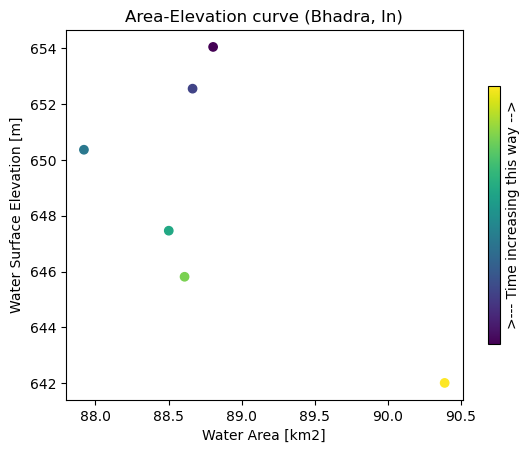

In [38]:
area_ts = merged['water_frac'].sum(dim=('x', 'y')) * 1e-6 * 1e4
wse_ts = merged['wse'].where(merged['water_frac'] > 0.5).mean(dim=('x', 'y'))

import matplotlib.pyplot as plt

f, ax = plt.subplots()

scatter = ax.scatter(area_ts, wse_ts, c=area_ts.time, cmap='viridis')
ax.set_title(f'Area-Elevation curve ({RESERVOIR_NAME})')
ax.set_xlabel('Water Area [km2]')
ax.set_ylabel('Water Surface Elevation [m]')

cbar = f.colorbar(scatter, shrink=0.7, label='>--- Time increasing this way -->')
cbar.ax.tick_params(size=0)
cbar.set_ticks([])

In [44]:
import panel as pn

date = 
water_frac_hv = merged['water_frac'].hvplot(
    x='x', y='y', geo=True
)
wse_hv = merged['wse'].hvplot(
    x='x', y='y', geo=True, clim=(120, 160)
)

pn.panel(water_frac_hv + wse_hv)

BokehModel(combine_events=True, render_bundle={'docs_json': {'ae6b6ecd-a032-481b-8279-82620d9fb404': {'version…

In [39]:
((
    swot_ds['surface_water']).hvplot(
        x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1) # , geo=True, # crs=swot_ds.rio.crs
).opts(
    title='Surface water'
) + (
    swot_ds['missing_mask']).hvplot(
        x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1), cmap='RdYlGn_r' # , geo=True, # crs=swot_ds.rio.crs
).opts(
    title='Missing mask'
) + (
    swot_ds['surface_water_elevation_raster']).hvplot(
        x='x', y='y', rasterize=True, aspect='equal'
).opts(
    title='Water Elevation'
) + (
    swot_ds['surface_water_area']).hvplot(
        label='Area', kind='scatter'
).opts(
    width=400, title='Area'
) + (
swot_ds['surface_water_elevation']).hvplot(
    label='Area', kind='scatter'
).opts(
    width=400, title='Water Surface Elevation'
) + (
swot_ds['missing_mask_rate']).hvplot(
    label='Area', kind='scatter'
).opts(
    width=400, title='Missing data rate'
)).cols(2)

BokehModel(combine_events=True, render_bundle={'docs_json': {'eee159df-0c88-4580-b852-7d4a41fa3b53': {'version…

##### end of notebook

In [40]:
# mask using water area quality flag
AREA_QUAL_FLAG_THRESHOLD = 2
ELEV_QUAL_FLAG_THRESHOLD = 2

ds['water_area'] = ds['water_area'].where(ds['water_area_qual'] <= AREA_QUAL_FLAG_THRESHOLD)
ds['water_frac'] = ds['water_frac'].where(ds['water_area_qual'] <= AREA_QUAL_FLAG_THRESHOLD)
ds['wse'] = ds['wse'].where(ds['wse_qual'] <= ELEV_QUAL_FLAG_THRESHOLD)

(ds['water_area']).hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Water Area'
) + ds['water_area_qual'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal' # , geo=True, # crs=ds.rio.crs
).opts(
    title='Water Area Quality'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'ef259f9d-cf43-4fb8-8681-5943cfda1c83': {'version…

In [41]:
# mask where water fraction is greater than a threshold
WATER_FRAC_THRESHOLD = 0.7

water_frac_mask = ds['water_frac'] > WATER_FRAC_THRESHOLD
ds['water_area'] = ds['water_area'].where(water_frac_mask)

(ds['water_area']).hvplot(
    x='x', y='y', rasterize=True, aspect='equal' , clim=(0, 1e4)# , geo=True, # crs=ds.rio.crs
).opts(
    title='Water Area (m2)'
) + ds['water_frac'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Water fraction'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'4d5e84da-da17-48da-af0e-90357c60af26': {'version…

In [42]:
(ds['water_area'].sum(dim=['x', 'y']) * 1e-6).hvplot.scatter()

:Scatter   [time]   (water_area)